## Getting Started With Geospatial Data Analysis 

This notebook covers the basics of getting started with Geospatial Data Analysis on SageMaker Studio. We start with exploring the sentinel geospatial dataset available at AWS open data registry. We explore deforestation data by analyzing [Sentinel-2](https://registry.opendata.aws/sentinel-2/) geospatial data and calculating spectral indices. Below is the example of XXXX. Similar concept will be used to identified forest cut temporal detection. 

## Install Packages (Optional)

Creating a environment in Studio is easy, by default sagemaker will have conda environment installed. you can use 'pip install' commands to to install required packages
below are the all the required packages for this workshop 
you only needs to install package first time when you create any notebook

In [ ]:
%pip install pandas
%pip install numpy
%pip install geopandas
#%pip install shapely
%pip install matplotlib
#%pip install plotly_express
%pip install sentinelhub
%pip install rasterio
#%pip install utils
#%pip install folium
%pip install earthpy
%pip install awswrangler

## Import Packages

After the environment is created and selected or the packages installed manually, we can import them directly.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
import os
import warnings
import datetime
import json
import boto3
import gc
import rasterio as rio
import os
import earthpy.spatial as es
import earthpy.plot as ep
import imageio
import io
import awswrangler as wr

%matplotlib inline
warnings.filterwarnings('ignore')

## Process the files and Save images output folder

Now we have files downloded in S3. We need find all the folders in the bucket. 
we will be using [AWS Data Wrangler](https://aws-sdk-pandas.readthedocs.io/en/2.16.1/index.html)

An [AWS Professional Service](https://aws.amazon.com/professional-services/) [open source](https://github.com/aws/aws-sdk-pandas) python initiative that extends the power of [Pandas](https://github.com/pandas-dev/pandas) library to AWS connecting DataFrames and AWS data related services.


We will be using [list_directories](https://aws-sdk-pandas.readthedocs.io/en/2.16.1/stubs/awswrangler.s3.list_directories.html#awswrangler.s3.list_directories) and [list_objects](https://aws-sdk-pandas.readthedocs.io/en/2.16.1/stubs/awswrangler.s3.list_objects.html#awswrangler.s3.list_objects) method. 

as name suggesest list_directories return list if folders in the current prefix and list_objects will return list if objects inside certain prefix.


In [7]:
# get the list of all the objects into the python list 
#s3objects = wr.s3.list_objects('<<bucket/tiles>>')
s3objects = wr.s3.list_objects('s3://reinvent22sentineldata/tiles')


In [8]:
print(s3objects)

['s3://reinvent22sentineldata/tiles/10/T/FK/2018/11/1/0/B04.jp2', 's3://reinvent22sentineldata/tiles/10/T/FK/2018/11/1/0/B08.jp2']


Now we will you can see that we have files at very deep level based on how sentinel-2 bucket stores the data

to process each files we want to have list of all the folder/prefix so we can iterate through the list.

In [9]:
# split the path and store list of prefix into the list.
s3folders = [item.rsplit('/',1)[0] for item in s3objects]

now you can see that there will be multiple files in one folder so to reduce looping lets keep only unique list items.

In [10]:
s3folders =np.unique(s3folders)

Lets validate that we have correct folder list

In [11]:
print(s3folders)

['s3://reinvent22sentineldata/tiles/10/T/FK/2018/11/1/0']


Now we have list of folders we will iterate through the files in each folders

## Working With Geospatial Images

For Geospatial data, we will use Sentinel-2. The [Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) is a land monitoring constellation of two satellites that provide high resolution optical imagery and continuity for the current SPOT and Landsat missions. The Sentinel-2 dataset is available publicly at the [AWS open data registry](https://registry.opendata.aws/sentinel-2/).

The Sentinel-2 satellites each carry a single multi-spectral instrument (MSI) with 13 spectral channels in the visible/near infrared (VNIR) and short wave infrared spectral range (SWIR). You can read more about these bands [here](https://en.wikipedia.org/wiki/Sentinel-2#Spectral_bands). 


Here is the table of the bands captured by Sentinel-2

|Band|Resolution|Description|
|---|---|---|
|B1	|60 m	|Ultra Blue (Coastal and Aerosol)|
|B2	|10 m	|Blue|
|B3	|10 m	|Green|
|B4	|10 m	|Red|
|B5	|20 m	|Visible and Near Infrared (VNIR)|
|B6	|20 m	|Visible and Near Infrared (VNIR)|
|B7	|20 m	|Visible and Near Infrared (VNIR)|
|B8	|10 m	|Visible and Near Infrared (VNIR)|
|B8a|20 m	|Visible and Near Infrared (VNIR)|
|B9	|60 m	|Short Wave Infrared (SWIR)|
|B10|60 m	|Short Wave Infrared (SWIR)|
|B11|20 m	|Short Wave Infrared (SWIR)|
|B12|20 m	|Short Wave Infrared (SWIR)|

## Working with Raster Data

Geospatial data is essentially comprised of raster data or vector data. Sentinel-2 uses GeoTIFF, a gridded raster datasets for satellite imagery and terrain models. [Rasterio is a Python library](https://rasterio.readthedocs.io/en/latest/) that allows to read, inspect, visualize and write geospatial raster data. Here we use rasterio to read thee raster arrays and then use this data to create a true color image.

In [12]:
from rasterio import plot
from rasterio.plot import show

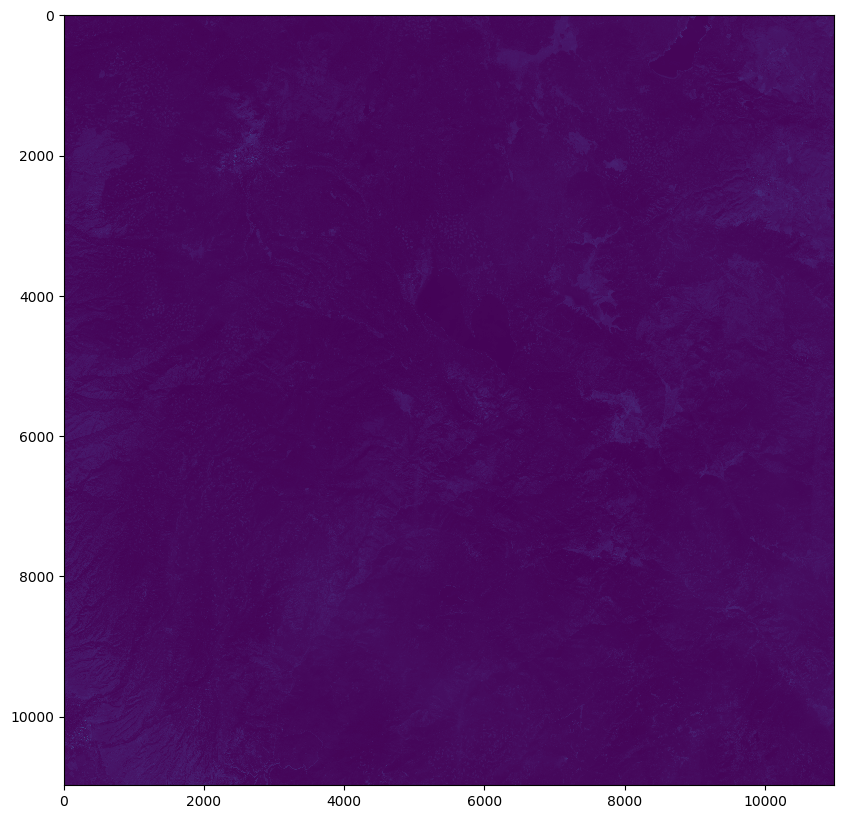

In [13]:
with rio.open('s3://reinvent22sentineldata/tiles/10/T/FK/2018/11/1/0/B04.jp2') as src:
    red = src.read()
plt.figure(figsize=[10,10],num=1, clear=True)
show(red) #RdYlGn
plt.show()

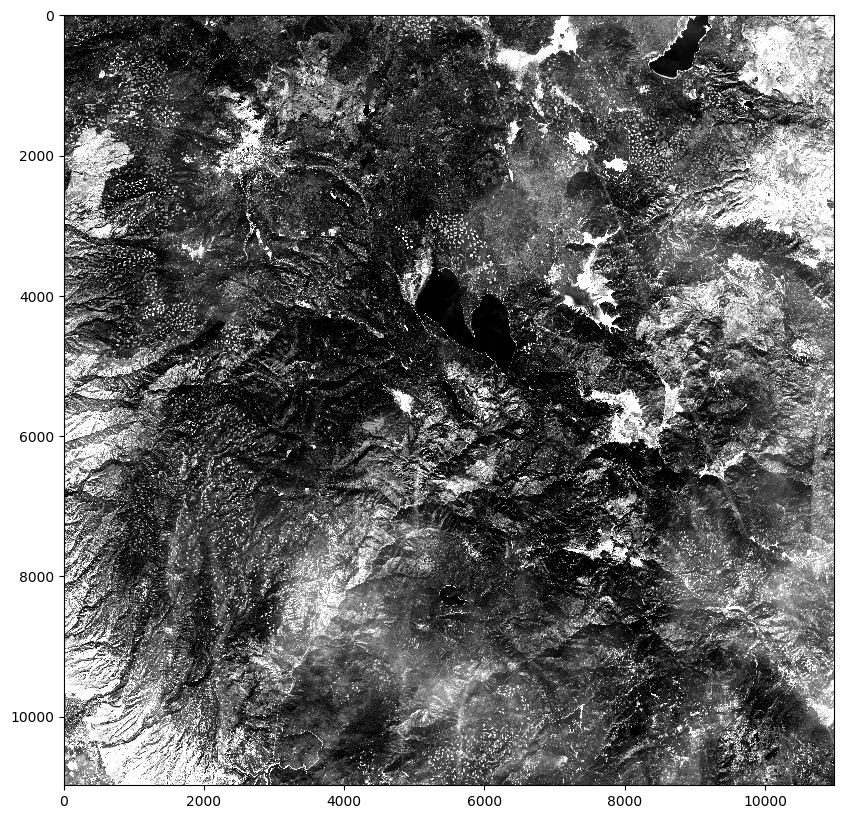

In [14]:
vmin, vmax = np.nanpercentile(red, (5,95))  # 5-95% contrast stretch
plt.figure(figsize=[10,10])
show(red, cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

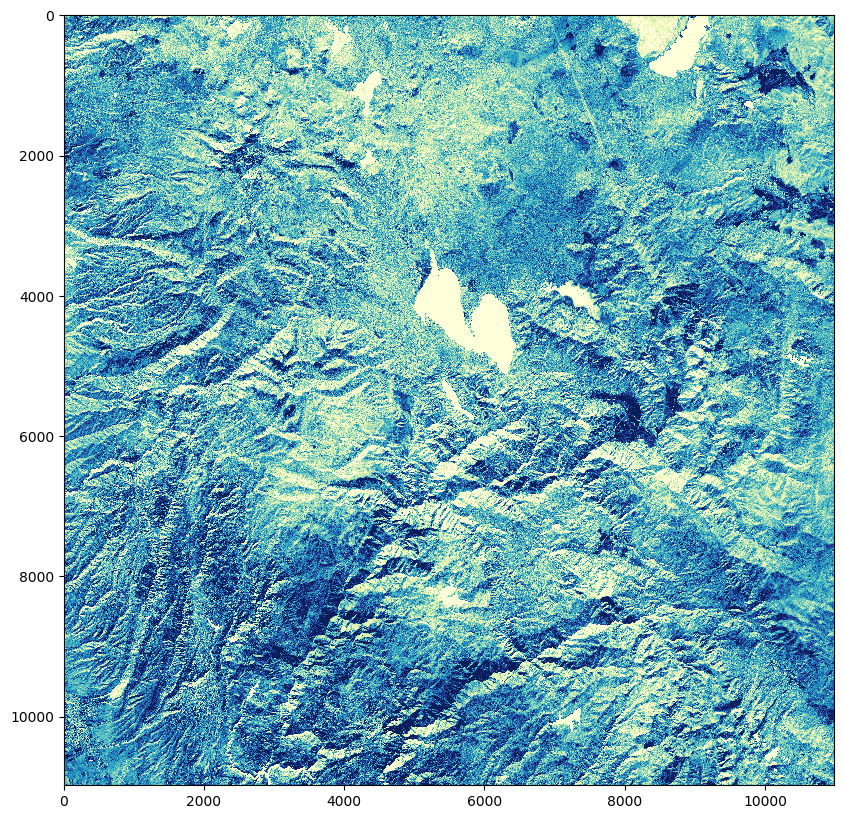

In [15]:
with rio.open('s3://reinvent22sentineldata/tiles/10/T/FK/2018/11/1/0/B08.jp2') as src:
    nir = src.read()
vmin, vmax = np.nanpercentile(nir, (5,95))  # 5-95% contrast stretch    
plt.figure(figsize=[10,10],num=1, clear=True)
show(nir, cmap='YlGnBu', vmin=vmin, vmax=vmax) #RdYlGn #YlGnBu
plt.show()


## Calculating Spectral Indices

Spectral indices are combinations of the pixel values from two or more spectral bands in a multispectral image. Spectral indices highlight pixels showing the relative abundance or lack of a land-cover type of interest in an image. Let's looks at a couple Wikipedia: [source](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index), visual example: [source](https://gisgeography.com/sentinel-2-bands-combinations/) 

## Normalized Difference Vegetation Index - NDVI

The normalized difference vegetation index is a simple graphical indicator that can be used to analyze whether or not the target being observed contains live green vegetation.
near-infrared (which vegetation strongly reflects) and red light (which vegetation absorbs), the vegetation index is good for quantifying the amount of vegetation. The formula for the normalized difference vegetation index is (B8-B4)/(B8+B4). While high values suggest dense canopy, low or negative values indicate urban and water features.

It calculated as NDVI = (B8 - B4) /(B8 + B4) or (NIR – Red) / (NIR + Red)


## Moisture Index 
The Moisture index is ideal for finding water stress in plants. It uses the short-wave and near-infrared to generate an index of moisture content. In general, wetter vegetation has higher values. But lower moisture index values suggest plants are under stress from insufficient moisture.

It calculated as (B8A - B11) / (B8A + B11)


Now that we already have processed B4 and B8 bands we can calculate Normalized Difference Vegetation Index 

In [16]:
#It calculated as NDVI = (B8 - B4) /(B8 + B4) or (NIR – Red) / (NIR + Red)
ndvisample = (nir.astype(float)-red.astype(float))/(nir.astype(float)+red.astype(float))

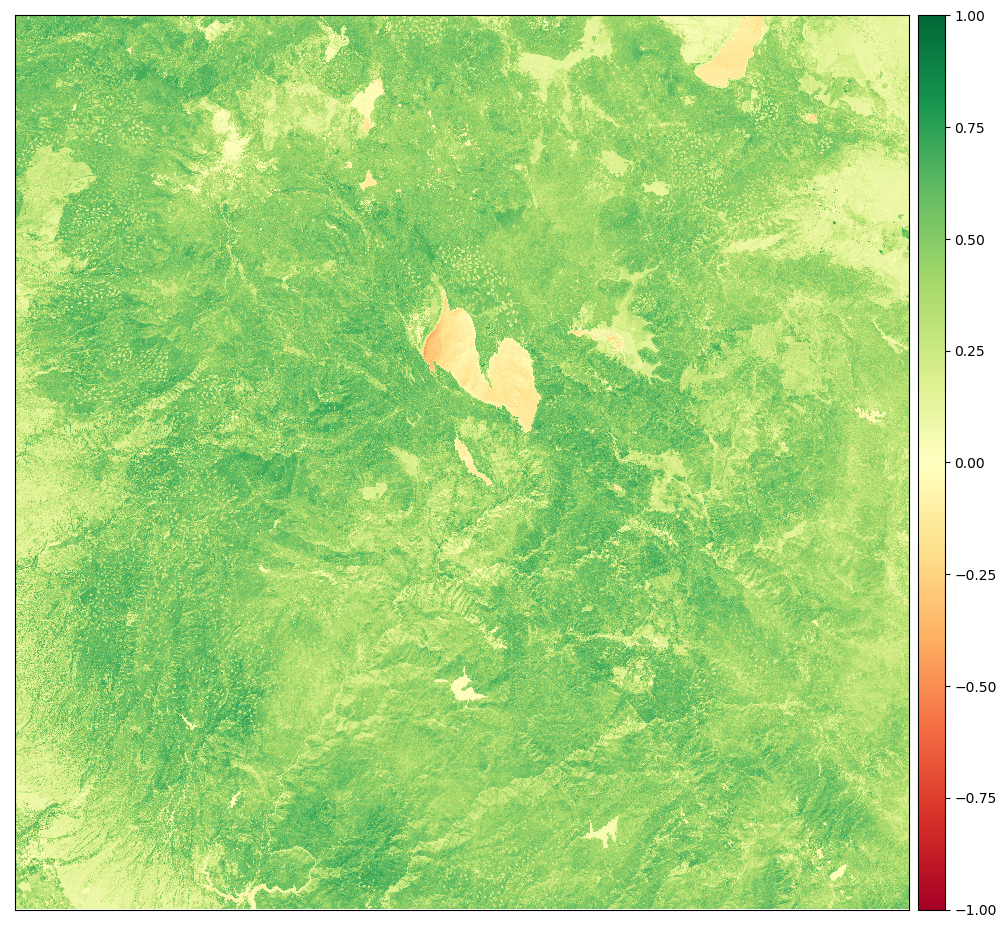

In [17]:
#we are using earthpy to visualize NDVI
ep.plot_bands(ndvisample, cmap="RdYlGn", vmin=-1, vmax=1);

Now lets apply this transformation to the date range we have downloded 

if you remember we have list if s3 folders in the variable: s3folders 
All the folders will have atleast two bands files B4 and B8 which will help us to calculate NDVI for each snapshot

### We will follow below process 
- we will loop through all the folders
- for each folder should have bands files 
- we will process B4 and B8 bands 
- calculate NDVI with formula  NDVI = (B8 - B4) /(B8 + B4)
- save the output image to a defined S3 bucket


In [18]:
#this function will save image to bucket
def savendviimage_s3(ndvi, BUCKET_NAME,KEY):


    
    fig = plt.figure(figsize=(10,10),num=1, clear=True)


    ax = ax = fig.add_subplot(111)

    # Use 'imshow' to specify the input data, colormap, min, max, and norm for the colorbar
    cbar_plot = ax.imshow(ndvi.squeeze(), cmap=plt.cm.RdYlGn , vmin=-1, vmax=1)


    # Turn off the display of axis labels 
    ax.axis('off')

    # Set a title 
    #ax.set_title('Normalized Difference Vegetation Index', fontsize=17, fontweight='bold')

    # Configure the colorbar
    #cbar = fig.colorbar(cbar_plot, orientation='vertical', shrink=0.65)

    img_data = io.BytesIO()
    #plt.savefig(img_data, format='png') #if you want to save files to files system
    
    # Call 'savefig' to save this plot to an image file
    fig.savefig(img_data, dpi=100, bbox_inches='tight', pad_inches=0, format='png')
    img_data.seek(0)
    
    
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(BUCKET_NAME)
    bucket.put_object(Body=img_data, ContentType='image/png', Key=KEY)
    
    

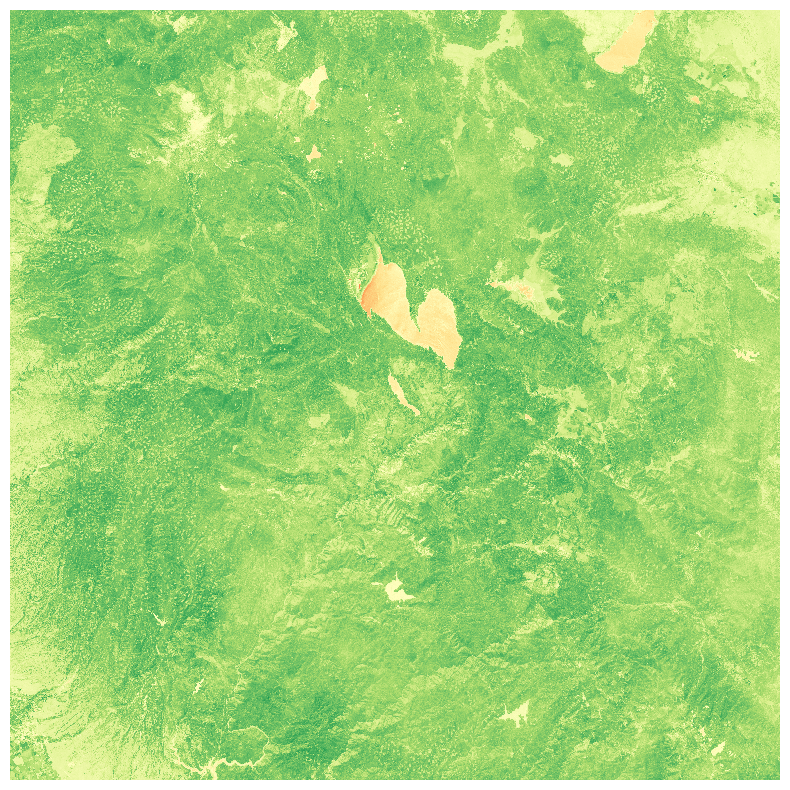

In [19]:
for folderpath in s3folders:
    files = wr.s3.list_objects(folderpath)
    for file in files:
        splittedpath = file.split('/')
        #define the imagename based on date
        imagename = splittedpath[-5]+splittedpath[-4]+splittedpath[-3]+'.png'
        if(file.find('B04.jp2')>-1):
            #read band b4 files
            with rio.open(file) as src:
                redfloat = src.read().astype(float)
        if(file.find('B08.jp2')>-1):
            with rio.open(file) as src:
                nirfloat = src.read().astype(float)
            #Calculate NDVI
            ndvi = (nirfloat-redfloat)/(nirfloat+redfloat)
            #Saveimage to s3 
            savendviimage_s3(ndvi,'reinvent22sentineldata','output/'+imagename)
            #for memory management
            if 'redfloat' in globals():
                del redfloat
            if 'nirfloat' in globals():
                del nirfloat
            if 'ndvi' in globals():
                del ndvi
            gc.collect()
            #print(imagename)

The above visualization shows us the classification of deforestation  plotted for region. You can see the dense forest area in dark green and dead forest or no forest in contrasting shades.

## Clean Up (Optional)

Though we did not create any AWS billable resources as part of this exercise, the geographic and GIS data that we downloaded and the images generated may take up significant storage. Make sure to check any storage utilization and delete the files as needed. 